## Installation

In [1]:
%pip install --upgrade pip
%pip install --upgrade circuitree==0.10.0 numpy scipy matplotlib tqdm ipympl ffmpeg watermark
%load_ext watermark
seed = 2024

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


# Quick start


## Problem statement

CircuiTree solves the following problem:

> Given a phenotype that can be simulated, a reward function that measures the phenotype, and a space of possible circuit architectures, find the optimal architecture(s) to achieve that target phenotype by running a reasonable number of simulations.


In order to solve this problem, CircuiTree uses a game-playing search algorithm called Monte Carlo tree search (MCTS), borrowed from artificial intelligence and reinforcement learning, to search over the space of possible architectures, or topologies. 

The main class provided by this package is `CircuiTree`, and to run a tree search, the user should make their own subclass of `CircuiTree` that defines a reward function and a space of possible topologies and uses MCTS to optimize topology with respect to the reward function.


In [2]:
from circuitree import CircuiTree


Let's consider a very simple example. Say we are interested in constructing a circuit of three transcription factors (TFs) A, B, and C that exhibits bistability, where the system can be "switched" from one state (e.g. high A, low B) to another (high B, low A). We will allow each TF to activate or inhibit any of the TFs (including itself). Multiple regulation (A both activates and inhibits B) is not allowed. With these rules, we have defined a set of topologies (a design space) that we are sampling from.


In [3]:
components = ["A", "B", "C"] # Three transcription factors (TFs)
interactions = [
    "activates", # Two options for each pairwise interaction between TFs
    "inhibits",
]


CircuiTree explores the design space by treating circuit design as a game where the topology is built step-by-step, and the objective is to assemble the best circuit. Specifically, `CircuiTree` represents each circuit topology as a string called a `state`, and it can choose from a list of `actions` that either change the `state` or terminate the assembly process (i.e. "click submit" on the game). The algorithm searches starting from a "root" state, and over many iterations it builds a decision tree of candidate topologies and preferentially explores regions of that tree with higher mean reward.

The rules for how states are defined and how they are affected by taking actions (i.e. the rules of the game) are called a "grammar." We will be using the built-in `SimpleNetworkGrammar` class to explore the design space we defined above. (See the grammar tutorial for more details on grammars and how to define custom design spaces from the base `CircuitGrammar` class.)

<!--
* `circuitree` treats circuit design as a game where the objective is to assemble a circuit topology with the highest probability of reward. In the game, you assemble a topology step-by-step. Starting from a root *state* of the game, you can add a new interaction to the topology diagram by choosing among the available *actions*. You always have the option of terminating the assembly sequence at the current state by choosing the "terminate" action, which "clicks submit" on the assembled topology and ends the game.
  - [image of assembly game with state, action labeled] -->

<!--
## Example based on adaptation paper - Ma, et al. Cell (2009)

* In this example, we will use MCTS to design a 4-component enzyme circuit that performs an function called adaptation. Adaptation is the ability of a system to buffer changes in an input stimulus and return to homeostatic levels.
* In our example, an input stimulus `I` activates the enzyme `A`, which then activates the downstream "output" enzyme `O`, and this interaction is regulated by the enzymes `B` and `C`. All species can activate or inhibit each other using first-order Michaelis-Menten kinetics.
  - [ODEs]
* We assume each enzyme has an active and an inactive state, represented by e.g. $A$ and $1-A$, respectively. Reaction rates depend on...  
* There are some more moving parts than I expected. Probably not worth implementing this whole thing in an example.
-->

<!--
* This example is a bit more complicated. I'll start with a simpler one
* In this exapmle, we will use MCTS to design a network of four transcription factors where the addition of an input stimulus $I$ causes a biphasic response in the output transcription factor $O$. Specifically, we use a target function $O^*(t)$ to represent the ideal dynamics - the concentration of $O$ should double, then halve, then return to baseline. For each topology, we will find the best-fit parameter set and declare success if the mean-squared deviation (MSD) between the observed $O(t)$ and $O^*(t)$ is below a threshold value of $0.1$.
  - [System of equations for O (with input), A, B, C]
  - [image showing O-star, an example simulation, and the least-squares fit]
  

* Specifically, we use a target function $O^*(t)$ to represent the ideal dynamics - the concentration of $O$ should double, then halve, then return to baseline. For each topology, we will find the best-fit parameter set and declare success if the mean-squared deviation (MSD) between the observed $O(t)$ and $O^*(t)$ is below a threshold value of $0.1$.
  - [System of equations for O (with input), A, B, C]
  - [image showing O-star, an example simulation, and the least-squares fit]

  
  -->


In [4]:
# Built-in grammars can be found in the `models` module
from circuitree.models import SimpleNetworkGrammar

grammar = SimpleNetworkGrammar(
    components=components,
    interactions=interactions,
)


Now we need to subclass `CircuiTree` and define a reward function. The reward function should return *bounded values*, ideally between 0 and 1. For our test case, bistability is known to require positive feedback. For example, positive autoregulation (A activates itself) or mutual inhibition (A inhibits B and B inhibits A). Here will use a dummy reward function that draws a random number from a Gaussian distribution, and we will increase the mean of that distribution if the state string contains PAR or mutual inhibition as a sub-pattern. Finally, we will categorize a topology as successful if its mean reward is >0.5.

<!--
In this example, we will use MCTS to design a network of transcription factors (TFs) that produces a specific kind of oscillation called predator-prey dynamics. The predator-prey system is classically modeled in ecology using the Lotka-Volterra model, which is a system of nonlinear differential equations in which a predator species $x$ grows by consuming a prey species $y$.

\begin{align}
\dot{x} &= a xy - b x \\
\dot{y} &= c y - d xy
\end{align}

Here, $b$ is the rate at which the predator species will die in the absence of prey to feed on, and $c$ is the rate at which the prey species will grow in the absence of predators. The growth of the predator population based on consuming prey depends on the parameter $a$, and the corresponding decline in prey population depends on the parameter $d$. This model predicts that under certain circumstances, the system will cycle between high-predator and high-prey conditions. -->


In [5]:
class BistabilityTree(CircuiTree):
    """A subclass of CircuiTree that searches for positive feedback networks. 
    Uses the SimpleNetworkGrammar to encode network topologies. In the 
    SimpleNetworkGrammar, each topology or 'state' is specified using a 3-part 
    string. For instance, a circuit with components 'A', 'B', and 'C' that
    repress each other in a cycle (i.e. the repressilator) would be represented
    as:

      *ABC::ABi_BCi_CAi

     - `::` separates circuit components from pairwise interactions
     - Components are uppercase letters, each type of interaction is a lowercase
       letter.
     - Pairwise interactions are 3-character strings. For exapmle, "ABi" means
       "A inhibits B"
     - A `*` at the beginning indicates that the state is terminal - the
       "termination" action was chosen, and the game has ended.
       
    The grammar can be accessed with the `self.grammar` attribute.
    """
    def __init__(self, grammar: SimpleNetworkGrammar, **kwargs) -> None:
        super().__init__(grammar=grammar, **kwargs)

    def get_reward(self, state: str) -> float:
        """Returns a reward value for the given state (topology) based on
        whether it contains positive-feedback loops (PFLs)."""

        # All types of PFLs with up to 3 components
        patterns = [
            "AAa", # PAR - "AAa" means "A activates A"
            "ABi_BAi", # Mutual inhibition - "A inhibits B, B inhibits A"
            "ABa_BAa", # Mutual activation
            "ABa_BCa_CAa", # Cycle of all activation
            "ABa_BCi_CAi", # Cycle with two inhibitions
        ]
        
        # Mean reward increases from 0.25 to 0.75 based on the number of PFLS.
        mean = 0.25
        for pattern in patterns:
            
            ## The "has_pattern" method returns whether state contains the pattern.
            ## It checks all possible symmetries, so we only need to specify 
            ## each pattern once (i.e. 'AAa' is equivalent to 'BBa' and 'CCa')
            if self.grammar.has_pattern(state, pattern):
                mean += 0.1
        
        # The CircuiTree object has its own random number generator
        return self.rg.normal(loc=mean, scale=0.1)

    def get_mean_reward(self, state: str) -> float:
        return (
            self.graph.nodes[state].get("reward", 0)
            / self.graph.nodes[state].get("visits", 1)
        )
        
    def is_success(self, state: str) -> bool:
        """Returns True if the state is terminal and a successful bistable
        circuit. The cumulative reward and number of visits are stored in the
        `reward` and `visits` attributes of each node in the graph.

        A state with no visits is assumed to have a mean reward of 0."""

        if not self.grammar.is_terminal(state):
            return False

        return self.get_mean_reward(state) > 0.5

Now we are ready to run a search! Let's run a search for 20,000 iterations, starting at a "root" state that doesn't have any interactions.

In [6]:
# Make an instance of the search tree
tree = BistabilityTree(
    grammar=grammar,
    root="ABC::", # The simplest (root) state has all 3 TFs but no interactions
)

# Run the search
tree.search_mcts(n_steps=100_000, progress_bar=True)

MCTS search: 100%|██████████| 100000/100000 [02:37<00:00, 634.25it/s]


Now we can parse the results. First, let's just plot the 10 circuit designs with the highest robustness, or average rate of reward.

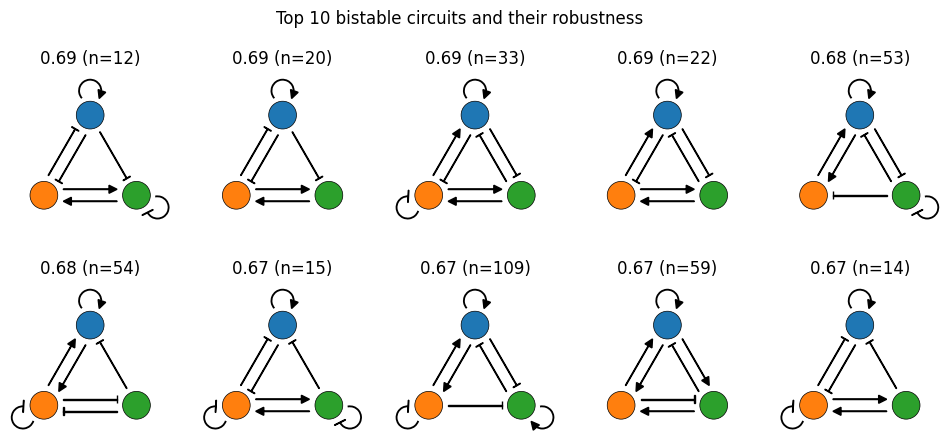

In [7]:
import matplotlib.pyplot as plt
from circuitree.viz import plot_network

%matplotlib inline

# Top 10 designs with at least 10 visits 
def robustness(state):
    r = tree.graph.nodes[state].get("reward", 0) 
    v = tree.graph.nodes[state].get("visits", 1)
    return r / v

# Recall that only the "terminal" states are fully assembled circuits
states = [s for s in tree.terminal_states if tree.graph.nodes[s]["visits"] > 10]
top_10_states = sorted(states, key=robustness, reverse=True)[:10]

# Plot the top 10 
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Top 10 bistable circuits and their robustness")
for i, state in enumerate(top_10_states):
    ax = fig.add_subplot(2, 5, i + 1)
    
    # Plots the network diagram
    plot_network(
        *grammar.parse_genotype(state), 
        ax=ax, 
        plot_labels=False, 
        node_shrink=0.6, 
        auto_shrink=0.8,
        offset=0.75,
        padding=0.4
    )
    r = tree.graph.nodes[state]["reward"]
    v = tree.graph.nodes[state]["visits"]
    ax.set_title(f"{r / v:.2f} (n={v})")
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.0, 1.8)

To visualize how the search process played out, we can view the whole search graph at once using a *complexity layout*.

(<Figure size 1500x500 with 2 Axes>,
 <Axes: title={'center': 'Moves with 10+ visits'}, ylabel='Complexity'>)

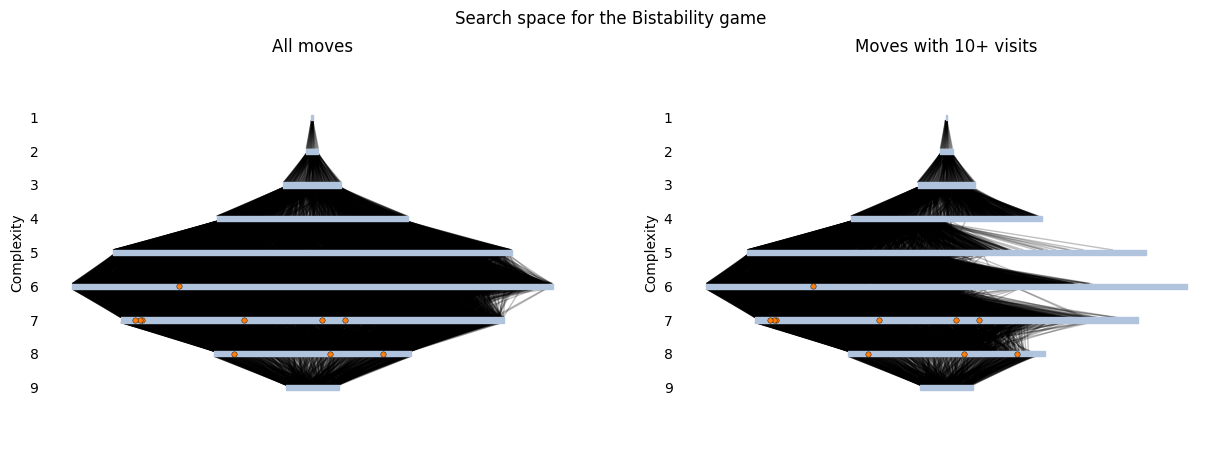

In [8]:
from circuitree.viz import plot_complexity

# Plotting options
plot_kwargs = dict(
    tree=tree,
    aspect=1.5,
    alpha=0.25,  # transparency of edges
    n_to_highlight=10,  # number of states to highlight with orange circles
    highlight_min_visits=10,  # only highlight states with 10+ visits
)
min_visits_per_move = 10

## Plot
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Search space for the Bistability game")

ax1 = fig.add_subplot(1, 2, 1)
plt.title("All moves")
plot_complexity(fig=fig, ax=ax1, **plot_kwargs)

ax2 = fig.add_subplot(1, 2, 2)
plt.title(f"Moves with {min_visits_per_move}+ visits")
plot_complexity(vlim=(min_visits_per_move, None), fig=fig, ax=ax2, **plot_kwargs)

Here, all the finished topologies are categorized into layers based on their complexity, or the number of interactions in the circuit diagram. The width of the layer represents the number of topologies with that complexity, and topologies within a layer are sorted from most visited to least visited during search. A line from a less complex topology $s_i$ to a more complex one $s_j$ indicates that the assembly move $s_i \rightarrow s_j$ was visited at least once (left) or at least ten times (right). Finally, we use orange circles to highlight the top 10 topologies shown above.

The graph on the left shows that the overall space is quite well sampled. In all the layers, even the least-visited states (on the right of each layer) have many incoming and outgoing edges, showing that many options were explored. If we only look at the moves with 10+ visits, the graph on the right shows that the search favored a subset of the overall graph that has a higher concentration of top solutions. This is great! It means that our search struck a good balance between exploring the overall space and focusing samples on high-reward areas.

Finally, let's make a video of our search process. First, we will run the search again, this time saving the tree object every 1,000 steps. To do that, we'll create a function that saves the tree and tell `search_mcts()` to call it every 500 iterations using the `callback` and `callback_every` keyword arguments. A callback is a function that is passed as an input to another function. We can use callbacks to perform periodic backups, save search metrics, or end the search early if a stopping condition is reached.

In [9]:
# Remember to remove the folder before re-running the below cell! 
# Otherwise, the video may contain multiple runs
!rm -r ./tree-backups

In [10]:

from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%y%m%d")

# Make a backup folder
save_dir = Path("./tree-backups")
save_dir.mkdir(exist_ok=True)

## Callbacks should have the following call signature: 
##       callback(tree, iteration, selection_path, simulated_node, reward)
## We only need the first two arguments to do a backup
def save_tree_callback(tree: BistabilityTree, iteration: int, *args, **kwargs):
    """Saves the BistabilityTree to two files, a `.gml` file containing the 
    graph and a `.json` file with the other attributes."""
    if iteration % 1_000 == 0:
        stem = f"{today}_bistability_search_{iteration}"
        gml_file = save_dir.joinpath(f"{stem}.gml")
        json_file = save_dir.joinpath(f"{stem}.json")
        tree.to_file(gml_file, json_file)

# Redo the search with periodic backup
n_steps = 100_000
tree = BistabilityTree(grammar=grammar, root="ABC::")
tree.search_mcts(
    n_steps=n_steps,
    progress_bar=True,
    callback=save_tree_callback,
    callback_every=500, 
)
print("Search complete!")

MCTS search: 100%|██████████| 100000/100000 [02:55<00:00, 568.62it/s]

Search complete!


Then, we can make the video using `matplotlib`'s `animation` interface. This might take a few minutes to run.

In [11]:
from matplotlib.animation import FuncAnimation

# Load the saved data in order of iteration
gml_files = sorted(save_dir.glob("*.gml"), key=lambda f: int(f.stem.split("_")[-1]))
json_files = sorted(save_dir.glob("*.json"), key=lambda f: int(f.stem.split("_")[-1]))
iterations = [int(f.stem.split("_")[-1]) for f in gml_files]

# Make an animation from each saved time-point
anim_dir = Path("./animations")
anim_dir.mkdir(exist_ok=True)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("All moves")
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Moves with 10+ visits")

def render_frame(f: int):
    """Render frame `f` of the animation."""
    ax1.clear()
    ax2.clear()
    
    tree = BistabilityTree.from_file(
        gml_files[f], json_files[f], grammar_cls=SimpleNetworkGrammar
    )
    
    plt.suptitle(f"Iteration {iterations[f]}")
    ax1.set_title("All moves")
    ax2.set_title("Moves with 10+ visits")
    plot_complexity(fig=fig, ax=ax1, tree=tree, aspect=1.5, alpha=0.25)
    plot_complexity(
        fig=fig, 
        ax=ax2, 
        tree=tree, 
        aspect=1.5, 
        alpha=0.25, 
        vlim=(10, None),
    )

# Make the animation
anim = FuncAnimation(fig, render_frame, frames=len(gml_files))
anim_file = anim_dir.joinpath(f"{today}_bistability.mp4")

# Save the animation
anim.save(
    anim_file, 
    writer="ffmpeg", 
    fps=10, 
    progress_callback=lambda i, n: print(f"{i + 1} / {n}")
)
print(f"Saved to: {anim_file}")

plt.close(fig)

1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
100 / 100
Saved to: animations/240426_bistability.mp4


Now let's watch the video!

In [12]:
from IPython.display import Video

Video(anim_file)

---

## Addendum: Custom grammars

The `circuitree.models` module contains the `SimpleNetworkGrammar` for pairwise interaction networks and the (experimental) `DimersNetworkGrammar` for networks where pairs of components dimerize to regulate a third. For any other applications, you should make your own grammar class by subclassing `CircuitGrammar`. 

This is an *abstract* class, which means that in order to use it, we must create a subclass that defines certain methods.

In [13]:
from circuitree import CircuitGrammar

print(f"To make a CircuitGrammar, define a subclass with the following methods:")
print(*[f"\t{m}" for m in CircuitGrammar.__abstractmethods__], sep="\n")

To make a CircuitGrammar, define a subclass with the following methods:
	get_actions
	do_action
	is_terminal
	get_unique_state


Here's a description of each function's call signature and what it should do:

```    
is_terminal(state) -> bool      # Return whether or not this state is terminal
get_actions(state) -> list[str] # Return a list of actions that can be taken from this state
do_action(state, action) -> str # Return a new state as a result of making this move
get_unique_state(state) -> str  # Return a unique representation of this state 
                                ### NOTE: This is used to account for cases where multiple
                                ### state strings represent the same architecture
```

As an example, let's write a grammar for an existing design space, explored by Angela Chau and colleagues in [this seminal paper](https://dx.doi.org/10.1016/j.cell.2012.08.040) to find polarization circuits. The authors were studying all possible network topologies with two membrane-bound enzymes A and B that have active and inactive forms, where each species can catalyze the forward and reverse reactions of the other species or of itself (autocatalysis). 

First, let's decide how to represent such a circuit as a string of characters. (Any `Hashable` representation can be used, but strings are convenient.) Let's use the following convention, which is the same one used by `SimpleNetworkGrammar`:
* Each component is an uppercase letter (`A` and `B`)
* Each type of interaction is a lowercase letter (`a` and `i` for activation and inhibition, respectively)
* Terminated (fully assembled) circuits start with `*`
* The set of components in a topology is a sequence of uppercase letters (`ABC`) 
* Components are separated from interactions by `::`
* Each interaction has a 3-character code, and interactions are separated by `_` (`ABa_BAi` means `A activates B and B inhibits A`)

For instance, the state string `*AB::ABi_BAi` denotes a terminally assembled circuit with components `A` and `B` that inhibit each other (i.e. a toggle switch). Let's write this as a class!

In [14]:
class PolarizationGrammar(CircuitGrammar):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def is_terminal(self, state: str) -> bool:
        """Returns True if the state is terminal and the game has ended."""
        return state.startswith("*")
    
    def get_actions(self, state: str) -> list[str]:
        """Returns a list of all possible actions from the given state."""
        # If termination hasn't happened yet, it's always a possibiilty
        if self.is_terminal(state):
            return []
        actions = ["*terminate*"]
        
        # Get the part of the string that contains the interactions
        interactions = state.split("::")[1]
        
        # Any pair of components that don't yet interact can interact. Each
        # addable 3-character interaction code is an action.
        for pair in ("AA", "AB", "BA", "BB"):
            if pair not in interactions:
                actions.append(pair + "a")
                actions.append(pair + "i")
        return actions

    def do_action(self, state, action):
        """Returns the new state after taking the given action"""
        if action == "*terminate*":
            return "*" + state

        prefix, interactions = state.split("::")
        if len(interactions) == 0:
            return f"{prefix}::{action}"
        else:
            return f"{prefix}::{interactions}_{action}"
    
    def get_unique_state(self, state):
        """Returns a unique representation of the state. Accounts for 
        the order of interactions by sorting them alphabetically."""
        prefix, interactions = state.split("::")
        if len(interactions) == 0:
            return state # No interactions to sort
        else:
            interactions_list = interactions.split("_")
            interactions = "_".join(sorted(interactions_list))
            return f"{prefix}::{interactions}"

```
>>> grammar = PolarizationGrammar()
>>> grammar.is_terminal("*AB::ABa_BAi")      # True
>>> grammar.get_actions("AB::ABa_BAi")       # ['*terminate*', 'AAa', 'AAi', 'BBa', 'BBi']
>>> grammar.do_action("AB::ABa_BAi", "AAa")  # 'AB::ABa_BAi_AAa'
>>> grammar.get_unique_state("*AB::BBa_BAi") # '*AB::BAi_BBa'
```
To run a tree search with this grammar, all we need to do is make our own subclass of `CircuiTree` that defines the `get_reward` function! We can also use the `grow_tree()` method to enumerate all 81 topologies in the space.

In [15]:
class PolarizationTree(CircuiTree):
    def __init__(self, *args, **kwargs):
        
        # Specify keyword arguments if they weren't supplied
        kwargs = {
            "grammar": PolarizationGrammar(),
            "root": "AB::" # Start with A and B with no interactions
        } | kwargs
        
        super().__init__(*args, **kwargs)
    
    def get_reward(self, state):
        """We're not running a search, so no need to implement a reward function"""
        return NotImplementedError


from pprint import pprint

tree = PolarizationTree()
tree.grow_tree()
terminal_states = list(tree.terminal_states)
print(f"# terminal states: {len(terminal_states)}")
print()
print("All terminal topologies:")
pprint(terminal_states)

# terminal states: 81

All terminal topologies:
['*AB::AAi_ABi_BAi_BBi',
 '*AB::AAa_ABi_BAi_BBi',
 '*AB::ABi_BAi_BBi',
 '*AB::AAi_ABa_BAi_BBi',
 '*AB::AAa_ABa_BAi_BBi',
 '*AB::ABa_BAi_BBi',
 '*AB::AAi_BAi_BBi',
 '*AB::AAa_BAi_BBi',
 '*AB::BAi_BBi',
 '*AB::AAi_ABi_BAa_BBi',
 '*AB::AAa_ABi_BAa_BBi',
 '*AB::ABi_BAa_BBi',
 '*AB::AAi_ABa_BAa_BBi',
 '*AB::AAa_ABa_BAa_BBi',
 '*AB::ABa_BAa_BBi',
 '*AB::AAi_BAa_BBi',
 '*AB::AAa_BAa_BBi',
 '*AB::BAa_BBi',
 '*AB::AAi_ABi_BBi',
 '*AB::AAa_ABi_BBi',
 '*AB::ABi_BBi',
 '*AB::AAi_ABa_BBi',
 '*AB::AAa_ABa_BBi',
 '*AB::ABa_BBi',
 '*AB::AAi_BBi',
 '*AB::AAa_BBi',
 '*AB::BBi',
 '*AB::AAi_ABi_BAi_BBa',
 '*AB::AAa_ABi_BAi_BBa',
 '*AB::ABi_BAi_BBa',
 '*AB::AAi_ABa_BAi_BBa',
 '*AB::AAa_ABa_BAi_BBa',
 '*AB::ABa_BAi_BBa',
 '*AB::AAi_BAi_BBa',
 '*AB::AAa_BAi_BBa',
 '*AB::BAi_BBa',
 '*AB::AAi_ABi_BAa_BBa',
 '*AB::AAa_ABi_BAa_BBa',
 '*AB::ABi_BAa_BBa',
 '*AB::AAi_ABa_BAa_BBa',
 '*AB::AAa_ABa_BAa_BBa',
 '*AB::ABa_BAa_BBa',
 '*AB::AAi_BAa_BBa',
 '*AB::AAa_BAa_BBa',


Note that if your design space is large (> 1 million states), `grow_tree()` can take an extremely long time, and the graph it is building may be too large for your computer's RAM.

---

In [16]:
%watermark -v -p circuitree,numpy,scipy,matplotlib,tqdm,jupyterlab,ipympl,ffmpeg,watermark

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.23.0

circuitree: 0.9.9
numpy     : 1.26.4
scipy     : 1.13.0
matplotlib: 3.8.4
tqdm      : 4.66.2
jupyterlab: 4.1.6
ipympl    : 0.9.4
ffmpeg    : 1.4
watermark : 2.4.3

